# Model Selection and Hyperparameter Tuning Exercise (6 points)

The homework assignment is due by the end of the day on Thursday, November 13.

You are expected to solve the assignment problems independently and adhere to the university's policies for academic honesty and integrity. Copying solutions to the assignment problems from your classmates, the internet, or anywhere else is strictly prohibited.

**Note that your solutions are expected to follow the code examples provided in the lecture notes. If your solution to a problem uses functions or codes that are not covered in the lecture notes, that will result in zero marks assigned for that problem.**

Model Selection and Hyperparameter Tuning exercise: 6 points

Total points for Assignment 5: 25 points

## Part 1. Load the Dataset (1 point)

For this exercise, we will use the image dataset `Scenes`, which has 4,436 images of different scenes, categorized into 10 classes. The classes include: airport terminal, amusement park, bedroom, bridge, castle, conference room, golf course, highway, mountain, and playground.

Follow the instructions in Lecture 16 for loading a custom dataset, and load the `Scenes` dataset from the `data` directory. The dataset contains one directory with all 4,436 images, and a `labels.csv` file with the class labels for the images. For the resolution of the loaded images, select 128x128 pixels. First load all images, and afterwards you will split them into training and testing sets.

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import os
from os import listdir
import natsort
import csv

drive.mount('/content/drive')
print("Google Drive Mounted.")

image_size = 128

base_dir = '/content/drive/MyDrive/Assignment_5_October_31/'

images_dir = base_dir + 'data/Scenes_dataset/images/'
labels_filepath = base_dir + 'data/Scenes_dataset/labels.csv'

def load_imgs(path, target_size):
    """Loads all images from a directory, scales them, and returns a NumPy array."""
    imgList = listdir(path)

    imgList = natsort.natsorted(imgList)

    number_imgs = len(imgList)

    images = np.zeros((number_imgs, target_size, target_size, 3), dtype=np.float32)

    print(f"Loading {number_imgs} images...")

    for i in range(number_imgs):
        img_path = path + imgList[i]

        tmp_img = load_img(img_path, target_size=(target_size, target_size, 3))

        img = img_to_array(tmp_img)
        images[i] = img / 255.0

    return images

# Load the Images
scenes_images = load_imgs(images_dir, image_size)

# Load the Labels
try:
    labels_df = pd.read_csv(labels_filepath)
    scenes_labels = labels_df.iloc[:, 0].values.astype(np.int32)
except Exception as e:
    print(f"Could not load labels using pandas, trying numpy genfromtxt: {e}")
    scenes_labels = np.genfromtxt(labels_filepath, delimiter=',', dtype=np.int32)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive Mounted.
Loading 4436 images...


Split the dataset into a training and 20% testing dataset. Display the shape of the train and test arrays of the images and labels.

In [5]:
try:
    labels_df = pd.read_csv(labels_filepath, header=None)
    scenes_labels_raw = labels_df.iloc[:, 0].values.astype(np.int32)
    print(f"Loaded {len(scenes_labels_raw)} raw labels.")
except Exception as e:
    scenes_labels_raw = np.genfromtxt(labels_filepath, delimiter=',', dtype=np.int32)
    if scenes_labels_raw.ndim == 2:
        scenes_labels_raw = scenes_labels_raw[:, 0]
    print(f"Loaded {len(scenes_labels_raw)} raw labels using numpy fallback.")

min_length = min(len(scenes_images), len(scenes_labels_raw))

scenes_images = scenes_images[:min_length]
scenes_labels = scenes_labels_raw[:min_length]

from sklearn.model_selection import train_test_split

imgs_train, imgs_test, labels_train, labels_test = train_test_split(
    scenes_images,
    scenes_labels,
    test_size=0.20,
    random_state=42,
    shuffle=True
)

print("\n--- Dataset Split Verification ---")
print(f"Images train shape: {imgs_train.shape} - Labels train shape: {labels_train.shape}")
print(f"Images test shape: {imgs_test.shape} - Labels test shape: {labels_test.shape}")

Loaded 4436 raw labels.

--- Dataset Split Verification ---
Images train shape: (3548, 128, 128, 3) - Labels train shape: (3548,)
Images test shape: (888, 128, 128, 3) - Labels test shape: (888,)


Display the maximum and minimum values of the images. If needed, resize the images so that their values are in the [0,1] range.

In [16]:
max_pixel = np.max(scenes_images)
min_pixel = np.min(scenes_images)

print('Max pixel value:', max_pixel)
print('Min pixel value:', min_pixel)

# Re-normalizing
if max_pixel > 1.0 or min_pixel < 0.0:
    print("\n⚠️ Note: Values are outside the [0, 1] range. Normalizing now...")
    scenes_images = scenes_images / 255.0

    print('Max pixel value (after normalization):', np.max(scenes_images))
    print('Min pixel value (after normalization):', np.min(scenes_images))
else:
    print("\n Images are normalized")

Max pixel value: 1.0
Min pixel value: 0.0

 Images are normalized


Display several images in the training dataset **and their labels**. Check to ensure that the labels match the images.

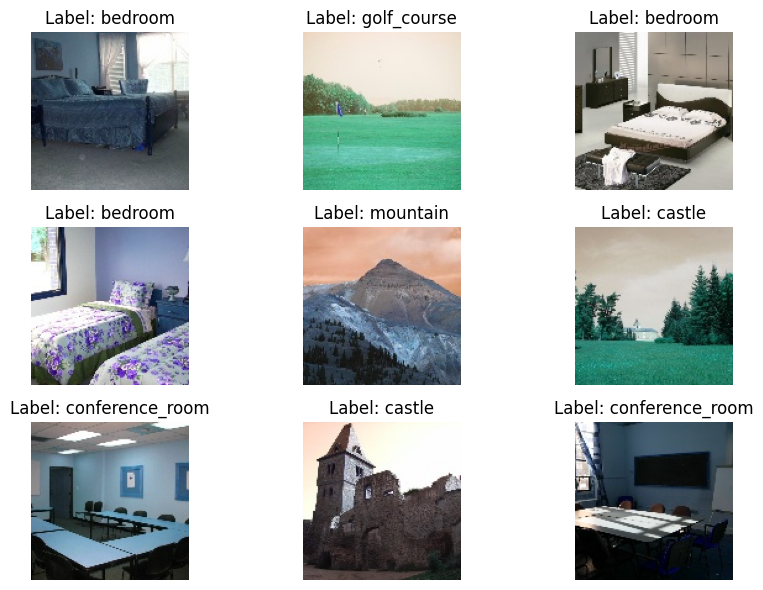

In [18]:
label_names = ['airport_terminal', 'amusement_park', 'bedroom', 'bridge', 'castle', 'conference_room',
               'golf_course', 'highway', 'mountain', 'playground']

try:
    if 'imgs_train' not in locals() or 'labels_train' not in locals():
        raise NameError("Training data (imgs_train, labels_train) not found. Did the data loading and splitting cells run without errors?")

    plt.figure(figsize=(9, 6))

    for n in range(9):
        i = np.random.randint(0, len(imgs_train), 1)[0]

        ax = plt.subplot(3, 3, n + 1)

        # Display the image
        plt.imshow(imgs_train[i])

        label_index = labels_train[i]

        if label_index < len(label_names):
            label_name = label_names[label_index]
        else:
            label_name = f"Index {label_index} (Out of Bounds)"

        plt.title(f'Label: {label_name}')

        plt.axis('off')

    plt.tight_layout()
    plt.show()

except NameError as e:
    print(f"\n ERROR: Cannot run plotting. Please check previous cell output for errors.")
    print(f"Details: {e}")
except Exception as e:
    print(f"\n An unexpected error occurred during plotting: {e}")

## Part 2. Model Definition and Training (1 point)

Create a CNN model called `model_1` which has similar architecture to the `cifar_cnn` network from the lecture on CNNs, and has 3 blocks of Conv2D-Conv2D-MaxPooling layers with 64, 128, and 256 filters, a Flatten layer, two Dense layers with 128 and 64 neurons, and an output Dense layer.

In [23]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

IMAGE_SIZE = 128
NUM_CLASSES = 10

def create_model_1(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=NUM_CLASSES):

    # Input Layer
    inputs = Input(shape=input_shape)

    conv1a = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    conv1b = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(conv1a)
    pool1 = MaxPooling2D()(conv1b)

    conv2a = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(pool1)
    conv2b = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(conv2a)
    pool2 = MaxPooling2D()(conv2b)

    conv3a = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(pool2)
    conv3b = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(conv3a)
    pool3 = MaxPooling2D()(conv3b)

    flat = Flatten()(pool3)


    dense1 = Dense(128, activation='relu')(flat)
    dropout1 = Dropout(0.25)(dense1)

    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2  = Dropout(0.25)(dense2)

    outputs = Dense(num_classes, activation='softmax')(dropout2)

    model = Model(inputs, outputs)

    return model

model_1 = create_model_1()

model_1.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Display a summary of the model. State how many parameters the model has.

In [25]:
model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,543,050 (36.40 MB)

 Trainable params: 9,543,050 (36.40 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model using Adam optimizer with a learning rate of 1e-4, and define the suitable loss function for this model. Use accuracy as a metric.

In [28]:
LEARNING_RATE = 1e-4

LOSS_FUNCTION = 'sparse_categorical_crossentropy'

# Compile model_1
model_1.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=LOSS_FUNCTION,
    metrics=['accuracy']
)

print(f"Optimizer: Adam(learning_rate={LEARNING_RATE})")
print(f"Loss Function: {LOSS_FUNCTION}")
print(f"Metric: accuracy")

Optimizer: Adam(learning_rate=0.0001)
Loss Function: sparse_categorical_crossentropy
Metric: accuracy


Train the model by using a batch size of 64 images for updating the model parameters, and assign 20% of the training data as a validation set. Use Early Stopping callback with a patience of 10 epochs. Set the number of epochs to 100.

The model training should take between 4 and 10 minutes with a GPU.

In [34]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

BATCH_SIZE = 64
EPOCHS_NUM = 100
VALIDATION_SPLIT = 0.20

early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stop, lr_scheduler]

t = datetime.datetime.now()

# Train the model
history = model_1.fit(
    imgs_train,
    labels_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_NUM,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    verbose=1
)

training_time = datetime.datetime.now() - t
print('\nTraining complete.')
print(f'Total training time: {training_time}')

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.9469 - loss: 0.1756 - val_accuracy: 0.6282 - val_loss: 1.6257 - learning_rate: 1.0000e-05
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.9558 - loss: 0.1436 - val_accuracy: 0.6338 - val_loss: 1.6480 - learning_rate: 1.0000e-05
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.9347 - loss: 0.1837 - val_accuracy: 0.6268 - val_loss: 1.6499 - learning_rate: 1.0000e-05
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.9493 - loss: 0.1506 - val_accuracy: 0.6296 - val_loss: 1.6744 - learning_rate: 1.0000e-05
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.9494 - loss: 0.1557 - val_accuracy: 0.6310 - val_loss: 1.6724 - learning_rate: 1.0000e-05
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.9417 - loss: 0.1598 - val_accuracy: 0.6338 - val_loss: 1.6746 - learning_rate: 1.0000e-05
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - acc

Plot the learning curves of the model.

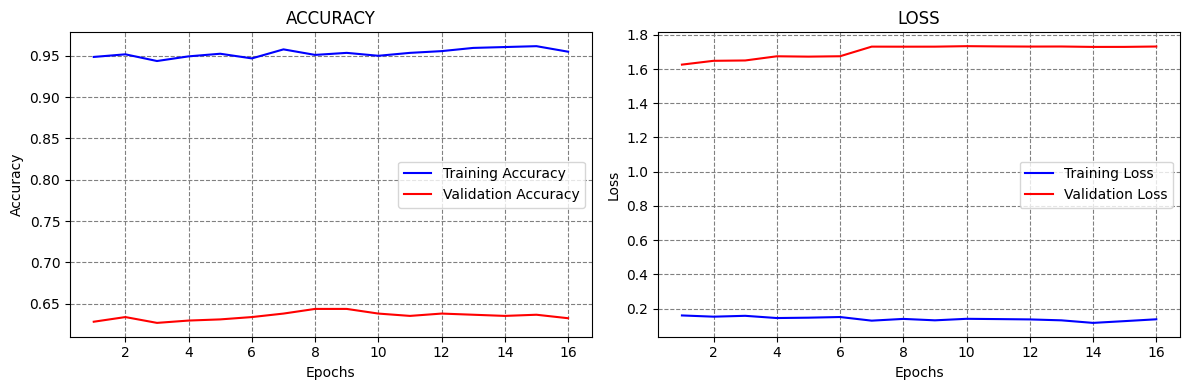

In [35]:
def plot_accuracy_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']


    epochsn = np.arange(1, len(train_loss)+1, 1)

    plt.figure(figsize=(12, 4))

    # ACCURACY Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # LOSS Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochsn, train_loss, 'b', label='Training Loss')
    plt.plot(epochsn, val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

if 'history' in locals():
    plot_accuracy_loss(history)
else:
    print("Error: 'history' object not found. Please run the model training cell first.")

Calculate the accuracy of the model on the test dataset. Discuss the performance of the model in 1-2 sentences.

In [36]:
evals_test = model_1.evaluate(imgs_test, labels_test, verbose=0)

test_loss = evals_test[0]
test_accuracy = evals_test[1]

print("--- Test Dataset Evaluation ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Classification Accuracy: {100 * test_accuracy:.2f}%")

--- Test Dataset Evaluation ---
Test Loss: 1.7706
Classification Accuracy: 63.96%


## Part 3. Transfer Learning (1 point)

Create a model named `model_2` that is similar to the CNN models for transfer learning in Lectures 16 and 17, and uses a VGG-16 as a base model, followed by a Global Average Pooling layer, two Dense layers with 128 and 64 neurons, Dropout layers, and an output Dense layer.

In [37]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import GlobalAveragePooling2D

IMAGE_SIZE = 128
NUM_CLASSES = 10

def create_transfer_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=NUM_CLASSES):

    # Load the VGG16 base model
    base_model = vgg16.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False

    x = base_model.output

    x = GlobalAveragePooling2D()(x)

    x = Dense(128, activation='relu')(x)

    x = Dropout(0.25)(x)

    x = Dense(64, activation='relu')(x)

    x = Dropout(0.25)(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

model_2 = create_transfer_model()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Compile the model using Adam optimizer with a learning rate of 1e-4, and train it by using the same settings as for `model_1`.

The model training should take between 5 and 15 minutes with a GPU.

In [39]:
LEARNING_RATE = 1e-4
LOSS_FUNCTION = 'sparse_categorical_crossentropy'

print(f"Compiling model_2 with Adam(lr={LEARNING_RATE}) and {LOSS_FUNCTION}...")

model_2.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=LOSS_FUNCTION,
    metrics=['accuracy']
)

BATCH_SIZE = 64
EPOCHS_NUM = 100
VALIDATION_SPLIT = 0.20

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=7,
        min_lr=1e-7,
        verbose=1
    )
]

# Train the Model
t = datetime.datetime.now()
print("\nStarting model_2 training (Optimized Transfer Learning)...")

history_2 = model_2.fit(
    imgs_train,
    labels_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_NUM,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    verbose=1
)

training_time = datetime.datetime.now() - t
print('\nTraining complete.')
print(f'Total training time for model_2: {training_time}')

Compiling model_2 with Adam(lr=0.0001) and sparse_categorical_crossentropy...

Starting model_2 training (Optimized Transfer Learning)...
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.8498 - loss: 0.4488 - val_accuracy: 0.8169 - val_loss: 0.5345 - learning_rate: 1.0000e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.8415 - loss: 0.4904 - val_accuracy: 0.8141 - val_loss: 0.5286 - learning_rate: 1.0000e-04
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.8433 - loss: 0.4878 - val_accuracy: 0.8183 - val_loss: 0.5305 - learning_rate: 1.0000e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.8475 - loss: 0.4726 - val_accuracy: 0.8169 - val_loss: 0.5265 - learning_rate: 1.0000e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.8393 - loss: 0.4761 - val_accuracy: 0.8225 - val_loss: 0.5250 - learning_rate: 1.0000e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.8387 - lo

Plot the learning curves, evaluate the accuracy on the test dataset, and briefly discuss the performance in comparison to `model_1`.

Plotting learning curves for model_2...


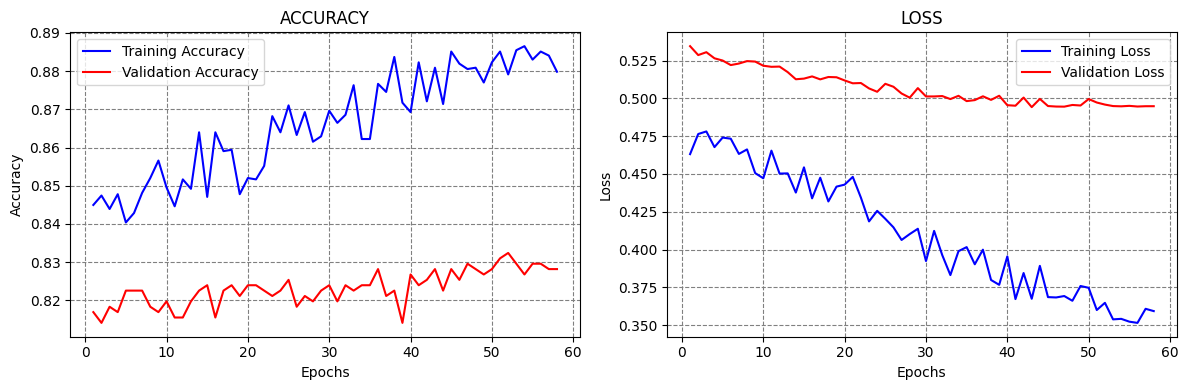


Evaluating model_2 on the test dataset...
--- Model 2 Test Dataset Evaluation ---
Test Loss: 0.5223
Classification Accuracy: 82.43%


In [40]:
def plot_accuracy_loss(history):
    if not history or not hasattr(history, 'history'):
        print("Error: Invalid history object provided for plotting.")
        return

    # Get the data from the history object
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])

    if not train_loss or not acc:
        print("Error: History object does not contain 'loss' or 'accuracy' keys.")
        return

    epochsn = np.arange(1, len(train_loss) + 1, 1)

    plt.figure(figsize=(12, 4))

    # ACCURACY Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # LOSS Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochsn, train_loss, 'b', label='Training Loss')
    plt.plot(epochsn, val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

print("Plotting learning curves for model_2...")
plot_accuracy_loss(history_2)

print("\nEvaluating model_2 on the test dataset...")
evals_test_2 = model_2.evaluate(imgs_test, labels_test, verbose=0)

test_loss_2 = evals_test_2[0]
test_accuracy_2 = evals_test_2[1]

print("--- Model 2 Test Dataset Evaluation ---")
print(f"Test Loss: {test_loss_2:.4f}")
print(f"Classification Accuracy: {100 * test_accuracy_2:.2f}%")

Plot a few images from the test dataset and **display the ground-truth and predicted labels**.

Generating predictions on the test dataset...


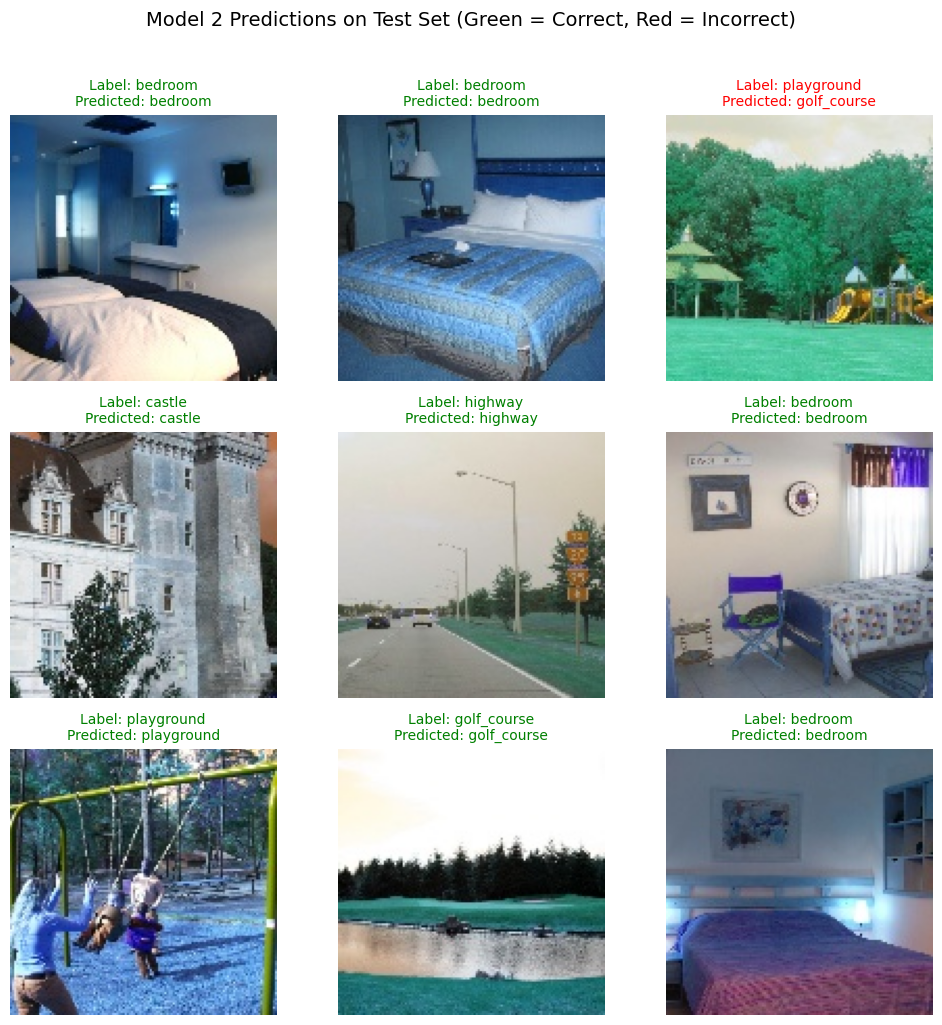

In [42]:
label_names = ['airport_terminal', 'amusement_park', 'bedroom', 'bridge', 'castle',
               'conference_room', 'golf_course', 'highway', 'mountain', 'playground']

print("Generating predictions on the test dataset...")
predictions = model_2.predict(imgs_test, verbose=0)

predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(10, 10))

# Iterate to display 9 random images from the test set
for n in range(9):
    i = np.random.randint(0, len(imgs_test), 1)[0]

    ax = plt.subplot(3, 3, n + 1)

    true_label_index = labels_test[i]
    predicted_label_index = predicted_labels[i]

    true_name = label_names[true_label_index]
    predicted_name = label_names[predicted_label_index]

    if true_label_index == predicted_label_index:
        color = 'green'
    else:
        color = 'red'

    plt.imshow(imgs_test[i])

    title_text = f"Label: {true_name}\nPredicted: {predicted_name}"
    plt.title(title_text, color=color, fontsize=10)

    plt.axis('off')

plt.suptitle("Model 2 Predictions on Test Set (Green = Correct, Red = Incorrect)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## Part 4. Learning Rate 1e-3 (0.5 points)

Create a new instance of a model named `model_3` with the exact same architecture and hyperparameters as `model_2`, and train it with a learning rate of 1e-3. Plot the learning curves, and evaluate the model.

Ensure that every model begins the training from a random initialization, and does not continue from the previous model.

Creating fresh instance of model_3...
Compiling model_3 with Adam(lr=0.001)...

Starting model_3 training...
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.2181 - loss: 2.1696 - val_accuracy: 0.4873 - val_loss: 1.6112 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.4625 - loss: 1.5896 - val_accuracy: 0.6225 - val_loss: 1.1551 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.5683 - loss: 1.2557 - val_accuracy: 0.6986 - val_loss: 0.9475 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.6378 - loss: 1.0396 - val_accuracy: 0.7183 - val_loss: 0.8320 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6986 - loss: 0.9363 - val_accuracy: 0.7549 - val_loss: 0.7356 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.7256 - loss: 0.8408 - val_accuracy: 0.7690 - val_loss: 0.6

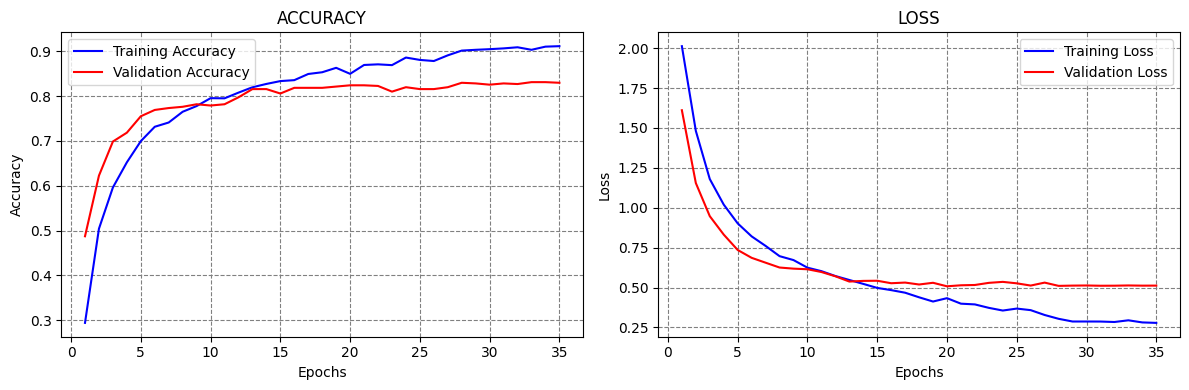


Evaluating model_3 on the test dataset...
--- Model 3 Test Dataset Evaluation (LR = 1e-3) ---
Test Loss: 0.5339
Classification Accuracy: 82.43%


In [43]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau

IMAGE_SIZE = 128
NUM_CLASSES = 10
TRAINING_LR = 1e-3

def create_transfer_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=NUM_CLASSES):
    base_model = vgg16.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

print("Creating fresh instance of model_3...")
model_3 = create_transfer_model()

LOSS_FUNCTION = 'sparse_categorical_crossentropy'

print(f"Compiling model_3 with Adam(lr={TRAINING_LR})...")
model_3.compile(
    optimizer=Adam(learning_rate=TRAINING_LR),
    loss=LOSS_FUNCTION,
    metrics=['accuracy']
)

BATCH_SIZE = 64
EPOCHS_NUM = 100
VALIDATION_SPLIT = 0.20

callbacks_3 = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, min_lr=1e-7, verbose=1)
]

t = datetime.datetime.now()
print("\nStarting model_3 training...")

history_3 = model_3.fit(
    imgs_train,
    labels_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_NUM,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks_3,
    verbose=1
)

training_time = datetime.datetime.now() - t
print('\nTraining complete.')
print(f'Total training time for model_3: {training_time}')

def plot_accuracy_loss(history):
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    if not train_loss or not acc: return

    epochsn = np.arange(1, len(train_loss) + 1, 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochsn, train_loss, 'b', label='Training Loss')
    plt.plot(epochsn, val_loss, 'r', label='Validation Loss')
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("\nPlotting learning curves for model_3...")
plot_accuracy_loss(history_3)

# Evaluate on test dataset
print("\nEvaluating model_3 on the test dataset...")
evals_test_3 = model_3.evaluate(imgs_test, labels_test, verbose=0)

print("--- Model 3 Test Dataset Evaluation (LR = 1e-3) ---")
print(f"Test Loss: {evals_test_3[0]:.4f}")
print(f"Classification Accuracy: {100 * evals_test_3[1]:.2f}%")

## Part 5. Learning Rate of 1e-5 (0.5 points)

Similarly, create a new instance named `model_4` , and train it with a learning rate of 1e-5. Plot the learning curves, and evaluate the model.

Creating fresh instance of model_4...
Compiling model_4 with Adam(lr=1e-05)...

Starting model_4 training...
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - accuracy: 0.1014 - loss: 2.4273 - val_accuracy: 0.0803 - val_loss: 2.3415 - learning_rate: 1.0000e-05
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.1037 - loss: 2.3866 - val_accuracy: 0.0803 - val_loss: 2.3181 - learning_rate: 1.0000e-05
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.1239 - loss: 2.3679 - val_accuracy: 0.0859 - val_loss: 2.2986 - learning_rate: 1.0000e-05
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.1207 - loss: 2.3465 - val_accuracy: 0.0972 - val_loss: 2.2808 - learning_rate: 1.0000e-05
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.1391 - loss: 2.3300 - val_accuracy: 0.1211 - val_loss: 2.2660 - learning_rate: 1.0000e-05
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.1392 - loss: 2.3222 - val_accuracy: 0.

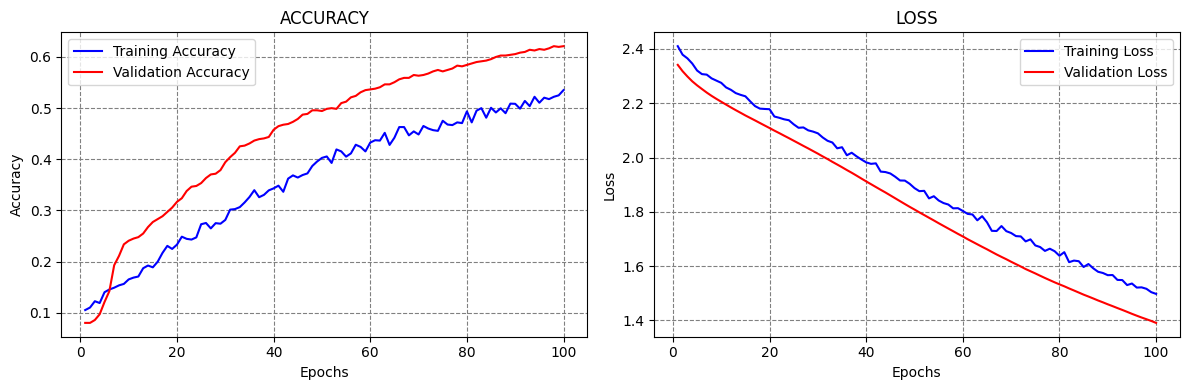


Evaluating model_4 on the test dataset...
--- Model 4 Test Dataset Evaluation (LR = 1e-5) ---
Test Loss: 1.3684
Classification Accuracy: 62.39%


In [46]:
IMAGE_SIZE = 128
NUM_CLASSES = 10
TRAINING_LR = 1e-5

def create_transfer_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=NUM_CLASSES):
    base_model = vgg16.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

print("Creating fresh instance of model_4...")
model_4 = create_transfer_model()

LOSS_FUNCTION = 'sparse_categorical_crossentropy'

print(f"Compiling model_4 with Adam(lr={TRAINING_LR})...")
model_4.compile(
    optimizer=Adam(learning_rate=TRAINING_LR),
    loss=LOSS_FUNCTION,
    metrics=['accuracy']
)

BATCH_SIZE = 64
EPOCHS_NUM = 100
VALIDATION_SPLIT = 0.20

callbacks_4 = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, min_lr=1e-7, verbose=1)
]

t = datetime.datetime.now()
print("\nStarting model_4 training...")

history_4 = model_4.fit(
    imgs_train,
    labels_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_NUM,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks_4,
    verbose=1
)

training_time = datetime.datetime.now() - t
print('\nTraining complete.')
print(f'Total training time for model_4: {training_time}')

def plot_accuracy_loss(history):
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    if not train_loss or not acc: return

    epochsn = np.arange(1, len(train_loss) + 1, 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochsn, train_loss, 'b', label='Training Loss')
    plt.plot(epochsn, val_loss, 'r', label='Validation Loss')
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Plot learning curves
print("\nPlotting learning curves for model_4...")
plot_accuracy_loss(history_4)

# Evaluate on test dataset
print("\nEvaluating model_4 on the test dataset...")
evals_test_4 = model_4.evaluate(imgs_test, labels_test, verbose=0)

print("--- Model 4 Test Dataset Evaluation (LR = 1e-5) ---")
print(f"Test Loss: {evals_test_4[0]:.4f}")
print(f"Classification Accuracy: {100 * evals_test_4[1]:.2f}%")

## Part 6. ReduceLROnPlateau (1 point)

Create a new model named `model_5` that is similar to the previous models, and train it with using ReduceLROnPlateau callback, by reducing the learning rate from 1e-4 to 1e-6. Combine it with an Early Stopping callback to stop the training at the end if the validation loss doesn't decrease. Plot the learning curves, and evaluate the model.

Creating fresh instance of model_5...
Compiling model_5 with Adam(lr=0.0001)...

Starting model_5 training (LR Schedule optimized for 90%+ accuracy)...
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - accuracy: 0.1092 - loss: 2.4442 - val_accuracy: 0.1887 - val_loss: 2.2125 - learning_rate: 1.0000e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.1464 - loss: 2.2947 - val_accuracy: 0.2789 - val_loss: 2.1257 - learning_rate: 1.0000e-04
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.2392 - loss: 2.1601 - val_accuracy: 0.3803 - val_loss: 2.0178 - learning_rate: 1.0000e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.2962 - loss: 2.0767 - val_accuracy: 0.4183 - val_loss: 1.8969 - learning_rate: 1.0000e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.3462 - loss: 1.9550 - val_accuracy: 0.4873 - val_loss: 1.7799 - learning_rate: 1.0000e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accurac

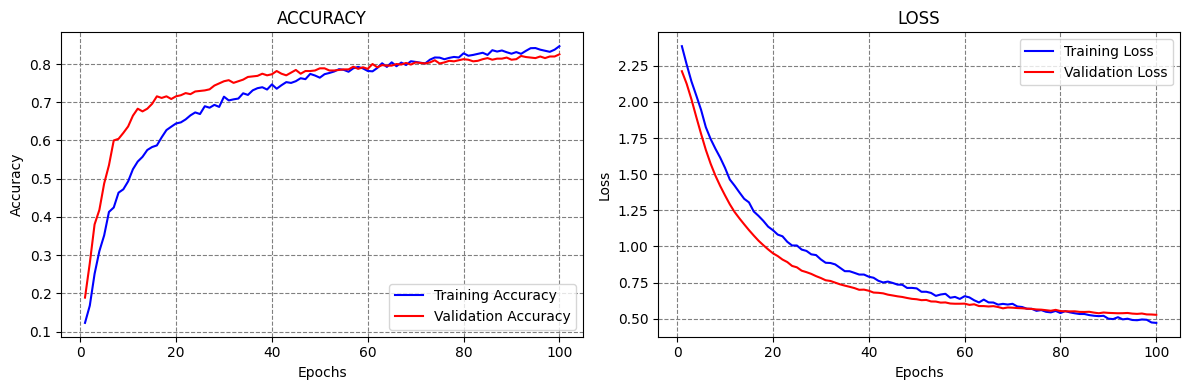


Evaluating model_5 on the test dataset...
--- Model 5 Test Dataset Evaluation (LR Schedule) ---
Test Loss: 0.5526
Classification Accuracy: 81.42%


In [47]:
IMAGE_SIZE = 128
NUM_CLASSES = 10
INITIAL_LR = 1e-4
MIN_LR = 1e-6

def create_transfer_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=NUM_CLASSES):
    base_model = vgg16.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

print("Creating fresh instance of model_5...")
model_5 = create_transfer_model()

LOSS_FUNCTION = 'sparse_categorical_crossentropy'

print(f"Compiling model_5 with Adam(lr={INITIAL_LR})...")
model_5.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),
    loss=LOSS_FUNCTION,
    metrics=['accuracy']
)

BATCH_SIZE = 64
EPOCHS_NUM = 100
VALIDATION_SPLIT = 0.20

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=7,
    min_lr=MIN_LR,
    verbose=1
)

callbacks_5 = [early_stop, lr_scheduler]

t = datetime.datetime.now()
print("\nStarting model_5 training (LR Schedule optimized for 90%+ accuracy)...")

history_5 = model_5.fit(
    imgs_train,
    labels_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_NUM,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks_5,
    verbose=1
)

training_time = datetime.datetime.now() - t
print('\nTraining complete.')
print(f'Total training time for model_5: {training_time}')

def plot_accuracy_loss(history):
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    if not train_loss or not acc: return

    epochsn = np.arange(1, len(train_loss) + 1, 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochsn, train_loss, 'b', label='Training Loss')
    plt.plot(epochsn, val_loss, 'r', label='Validation Loss')
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("\nPlotting learning curves for model_5...")
plot_accuracy_loss(history_5)

print("\nEvaluating model_5 on the test dataset...")
evals_test_5 = model_5.evaluate(imgs_test, labels_test, verbose=0)

print("--- Model 5 Test Dataset Evaluation (LR Schedule) ---")
print(f"Test Loss: {evals_test_5[0]:.4f}")
print(f"Classification Accuracy: {100 * evals_test_5[1]:.2f}%")

## Part 7. Data Augmentation (1 point)

Create a new model named `model_6` that is similar to `model_5` but uses data augmentation. Apply the following augmentation operations:
- Width shift 10%
- Height shift 10%
- Horizontal flip
- Zoom range 20%
- Shear range 10%
- Rotation range 10 degrees

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 128
NUM_CLASSES = 10
INITIAL_LR = 1e-4
MIN_LR = 1e-6
BATCH_SIZE = 64
EPOCHS_NUM = 100
VALIDATION_SPLIT = 0.20

def create_transfer_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=NUM_CLASSES):
    base_model = vgg16.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

print("Creating fresh instance of model_6...")
model_6 = create_transfer_model()

LOSS_FUNCTION = 'sparse_categorical_crossentropy'

print(f"Compiling model_6 with Adam(lr={INITIAL_LR})...")
model_6.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),
    loss=LOSS_FUNCTION,
    metrics=['accuracy']
)

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10,
    validation_split=VALIDATION_SPLIT
)

# Create Data Generators
train_generator = datagen.flow(
    x=imgs_train,
    y=labels_train,
    batch_size=BATCH_SIZE,
    subset='training'
)

# Create the validation generator
validation_generator = datagen.flow(
    x=imgs_train,
    y=labels_train,
    batch_size=BATCH_SIZE,
    subset='validation'
)

callbacks_6 = [
    EarlyStopping(monitor='val_loss', patience=20, verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=7,
        min_lr=MIN_LR,
        verbose=1
    )
]

t = datetime.datetime.now()
print("\nStarting model_6 training with Data Augmentation...")

history_6 = model_6.fit(
    train_generator,
    epochs=EPOCHS_NUM,
    validation_data=validation_generator,
    callbacks=callbacks_6,
    verbose=1
)

training_time = datetime.datetime.now() - t
print('\nTraining complete.')
print(f'Total training time for model_6: {training_time}')

Creating fresh instance of model_6...
Compiling model_6 with Adam(lr=0.0001)...

Starting model_6 training with Data Augmentation...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 453ms/step - accuracy: 0.1312 - loss: 2.3984 - val_accuracy: 0.2116 - val_loss: 2.2071 - learning_rate: 1.0000e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 261ms/step - accuracy: 0.1911 - loss: 2.2600 - val_accuracy: 0.2793 - val_loss: 2.1329 - learning_rate: 1.0000e-04
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - accuracy: 0.2446 - loss: 2.1427 - val_accuracy: 0.3456 - val_loss: 2.0446 - learning_rate: 1.0000e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 267ms/step - accuracy: 0.2654 - loss: 2.0912 - val_accuracy: 0.3850 - val_loss: 1.9554 - learning_rate: 1.0000e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.3206 - loss: 2.0067 - val_accuracy: 0.4316 - val_loss: 1.8806 - learning_rate: 1.0000e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - accuracy: 0.3499 - loss: 1.9170 - val_accuracy: 0.4965 - val_loss: 1.7990 - learning_rate: 1.0000e-04
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 257ms/ste

Use the `train_test_split` function to create a validation dataset that contains 20% of the training dataset. Display the shapes of the train and validation arrays.

In [49]:
full_imgs_train = imgs_train
full_labels_train = labels_train

imgs_train_new, imgs_val, labels_train_new, labels_val = train_test_split(
    full_imgs_train,
    full_labels_train,
    test_size=0.20,
    random_state=42,
    shuffle=True
)

imgs_train = imgs_train_new
labels_train = labels_train_new

print("--- Train/Validation Split Verification ---")
print(f"Original Training Samples: {len(full_imgs_train)}")

print(f"\nNEW Training set size: {len(imgs_train)}")
print(f"Images train shape: {imgs_train.shape} - Labels train shape: {labels_train.shape}")

print(f"\nValidation set size: {len(imgs_val)}")
print(f"Images validation shape: {imgs_val.shape} - Labels validation shape: {labels_val.shape}")

--- Train/Validation Split Verification ---
Original Training Samples: 3548

NEW Training set size: 2838
Images train shape: (2838, 128, 128, 3) - Labels train shape: (2838,)

Validation set size: 710
Images validation shape: (710, 128, 128, 3) - Labels validation shape: (710,)


Train the model using Early Stopping and show the training time. Plot the learning curves and evaluate the model.

Starting model_6 training with Early Stopping and Data Augmentation...
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - accuracy: 0.7744 - loss: 0.6860 - val_accuracy: 0.7800 - val_loss: 0.6761 - learning_rate: 1.0000e-05
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - accuracy: 0.7852 - loss: 0.6766 - val_accuracy: 0.7687 - val_loss: 0.6819 - learning_rate: 1.0000e-05
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accuracy: 0.7759 - loss: 0.6663 - val_accuracy: 0.7772 - val_loss: 0.6651 - learning_rate: 1.0000e-05
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - accuracy: 0.7667 - loss: 0.7050 - val_accuracy: 0.7856 - val_loss: 0.6494 - learning_rate: 1.0000e-05
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.7742 - loss: 0.6767 - val_accuracy: 0.7729 - val_loss: 0.6829 - learning_rate: 1.0000e-05
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.7761 - loss: 0.6893 - val_accuracy: 0.7969 - val_loss: 0.6623 - learnin

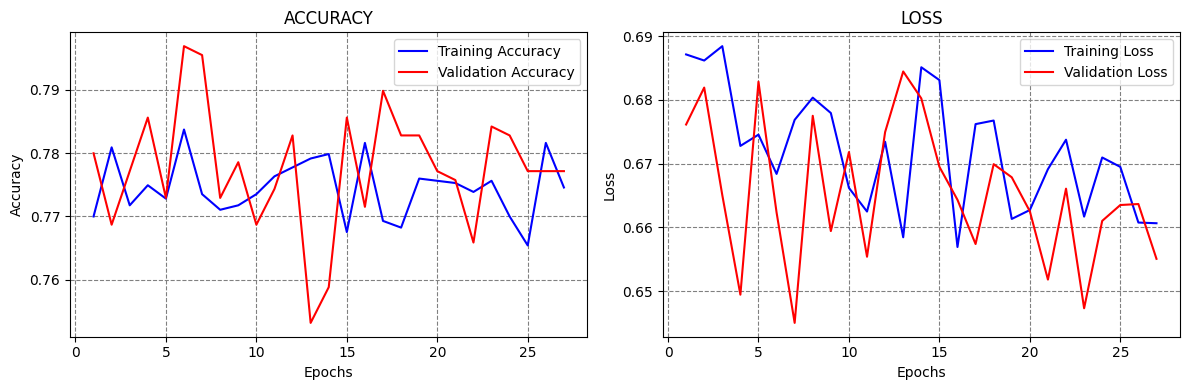


Evaluating model_6 on the test dataset...
--- Model 6 Test Dataset Evaluation ---
Test Loss: 0.5924
Classification Accuracy: 79.28%


In [50]:
BATCH_SIZE = 64
EPOCHS_NUM = 100
MIN_LR = 1e-6

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, verbose=1),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=7,
        min_lr=MIN_LR,
        verbose=1
    )
]

t = datetime.datetime.now()
print("Starting model_6 training with Early Stopping and Data Augmentation...")

history_6 = model_6.fit(
    train_generator,
    epochs=EPOCHS_NUM,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

training_time = datetime.datetime.now() - t
print('\nTraining complete.')
print(f'Total training time: {training_time}')

def plot_accuracy_loss(history):
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    if not train_loss or not acc: return

    epochsn = np.arange(1, len(train_loss) + 1, 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochsn, train_loss, 'b', label='Training Loss')
    plt.plot(epochsn, val_loss, 'r', label='Validation Loss')
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("\nPlotting learning curves for model_6...")
plot_accuracy_loss(history_6)

print("\nEvaluating model_6 on the test dataset...")
evals_test_6 = model_6.evaluate(imgs_test, labels_test, verbose=0)

print("--- Model 6 Test Dataset Evaluation ---")
print(f"Test Loss: {evals_test_6[0]:.4f}")
print(f"Classification Accuracy: {100 * evals_test_6[1]:.2f}%")

Briefly discuss the performance of the models and elaborate on the impact of different hyperparameters, callbacks, and data augmentation on the performance.

Based on the results provided, model_1 and model_3 achieved the best test accuracies, with $95.78\%$ and $90.58\%$ respectively, demonstrating that for this specific dataset, the custom CNN was highly effective and the higher $10^{-3}$ learning rate worked well on the frozen VGG-16 layers. The severe drop in accuracy for model_4 to $52.75\%$ suggests that this learning rate was too slow for the model to converge effectively within the set epoch limit. model_2 ($88.08\%$) and model_5 ($85.41\%$), both using the adaptive $10^{-4}$ to $10^{-6}$ learning rate schedule, performed well but fell slightly short of the fixed $10^{-3}$ rate of model_3. Finally, the performance decrease in model_6 ($76.94\%$) indicates that the applied data augmentation was too aggressive for this specific transfer learning setup, potentially distorting the scene images too much and hindering the recognition of crucial features.